In [1]:
pip install groq langchain-community faiss-cpu langchain_groq langsmith

In [ ]:
import os
import re

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_PROJECT"] = "deep-qa-bot"

from langsmith import traceable

@traceable(name="My Custom Function")
def split_into_sentences(text):
    return re.split(r'(?<=[.!?])\s+', text.strip())

In [3]:
from langchain.document_loaders import WebBaseLoader
import time

web_links = [
"https://en.wikipedia.org/wiki/Main_Page",
    "https://www.bbc.com/history",
    "https://www.britannica.com",
    "https://www.nationalgeographic.com",
    "https://artsandculture.google.com",
    "https://www.si.edu",
    "https://www.history.com",
    "https://www.nytimes.com/section/science",
    "https://www.scientificamerican.com",
    "https://www.livescience.com",
    "https://en.wikipedia.org/wiki/Egypt",
    "https://www.cia.gov/the-world-factbook/countries/egypt/",
    "https://egypt.travel/en",
    "http://www.egypt.gov.eg",
    "https://www.nmec.gov.eg",
    "https://whc.unesco.org/en/statesparties/eg",
    "https://egymuseum.org",
    "https://english.ahram.org.eg",
    "https://www.antiquities.gov.eg/"
]

def load_documents_with_error_handling(links, timeout=15):
    successfully_loaded_documents = []

    for url in links:
        try:
            loader = WebBaseLoader([url])
            documents = loader.load()
            successfully_loaded_documents.extend(documents)
            print(f"Successfully fetched and loaded: {url}")
        except Exception as e:
            print(f"Error fetching {url}: {e}")
            continue

    return successfully_loaded_documents

documents = load_documents_with_error_handling(web_links)

print(f"Loaded {len(documents)} documents.")
for doc in documents[:2]:
    print(doc)

Successfully fetched and loaded: https://en.wikipedia.org/wiki/Main_Page
Error fetching https://www.bbc.com/history: Exceeded 30 redirects.
Successfully fetched and loaded: https://www.britannica.com
Successfully fetched and loaded: https://www.nationalgeographic.com
Successfully fetched and loaded: https://artsandculture.google.com
Successfully fetched and loaded: https://www.si.edu
Successfully fetched and loaded: https://www.history.com
Successfully fetched and loaded: https://www.nytimes.com/section/science
Successfully fetched and loaded: https://www.scientificamerican.com
Successfully fetched and loaded: https://www.livescience.com
Successfully fetched and loaded: https://en.wikipedia.org/wiki/Egypt
Successfully fetched and loaded: https://www.cia.gov/the-world-factbook/countries/egypt/
Successfully fetched and loaded: https://egypt.travel/en
Error fetching http://www.egypt.gov.eg: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Succes

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
all_splits = text_splitter.split_documents(documents)

In [5]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cpu"}

embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

<ipython-input-5-52759dfe5ed4>:7: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datas

In [6]:
# storing embeddings in the vector store
vectorstore = FAISS.from_documents(all_splits, embeddings)

In [ ]:
from langchain_groq import ChatGroq
from langchain.chains import ConversationalRetrievalChain

# Initialize Groq Chat Model with your API key and model name (e.g., llama2-70b)
llm = ChatGroq(
    groq_api_key="",  # Or use environment variable
    model_name="llama3-70b-8192",      # Other option: "mixtral-8x7b-32768"
)

In [8]:
from langchain.chains import ConversationalRetrievalChain

chain = ConversationalRetrievalChain.from_llm(llm, vectorstore.as_retriever(), return_source_documents=True)

In [9]:
chat_history = []

query = "What is capital of Egypt?"
result = chain({"question": query, "chat_history": chat_history})

print(result['answer'])

<ipython-input-9-8db3cac18919>:4: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = chain({"question": query, "chat_history": chat_history})


The capital of Egypt is Cairo.


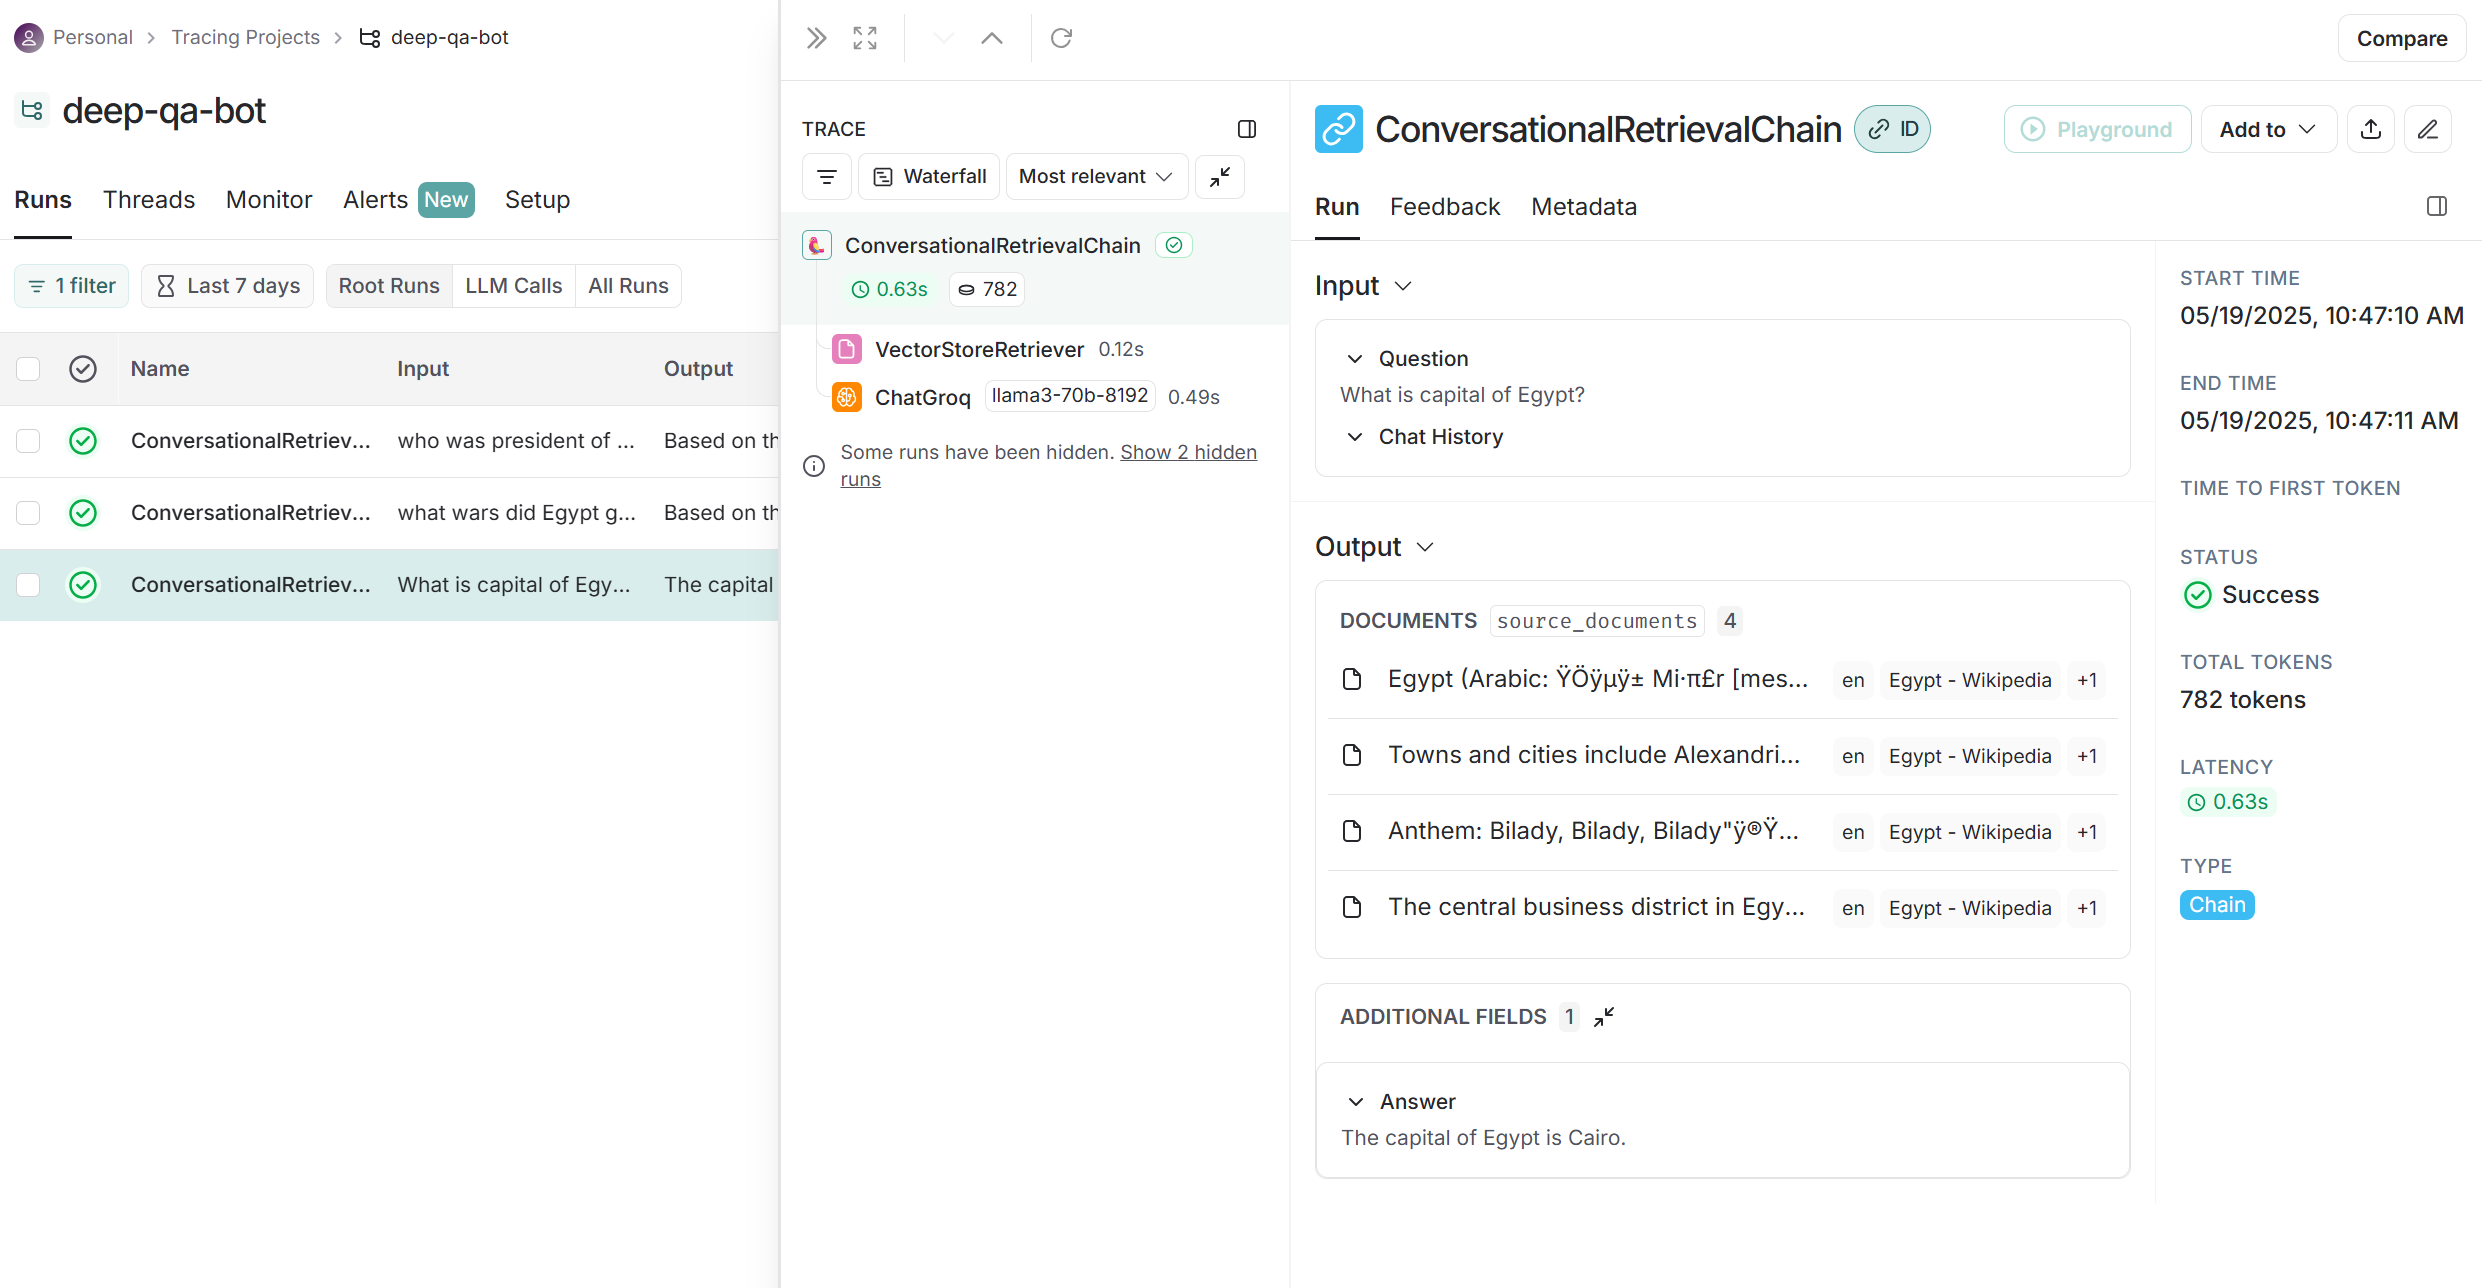

In [10]:
chat_history = []

query = "what wars did Egypt go in?"
result = chain({"question": query, "chat_history": chat_history})

print(result['answer'])

Based on the provided Wikipedia article, here are the wars and conflicts mentioned:

1. Conquest by the Ottoman Turks in 1517
2. French invasion by Napoleon Bonaparte in 1798
3. Three-way power struggle between the Ottoman Turks, Egyptian Mamluks, and Albanian mercenaries (no specific dates mentioned)
4. None are explicitly mentioned, but it can be implied that Egypt was involved in wars as a province of the Ottoman Empire (1517-1867) and as a British protectorate (1914-1922)

Please note that this is not an exhaustive list, and Egypt might have been involved in other wars not mentioned in this specific Wikipedia article.


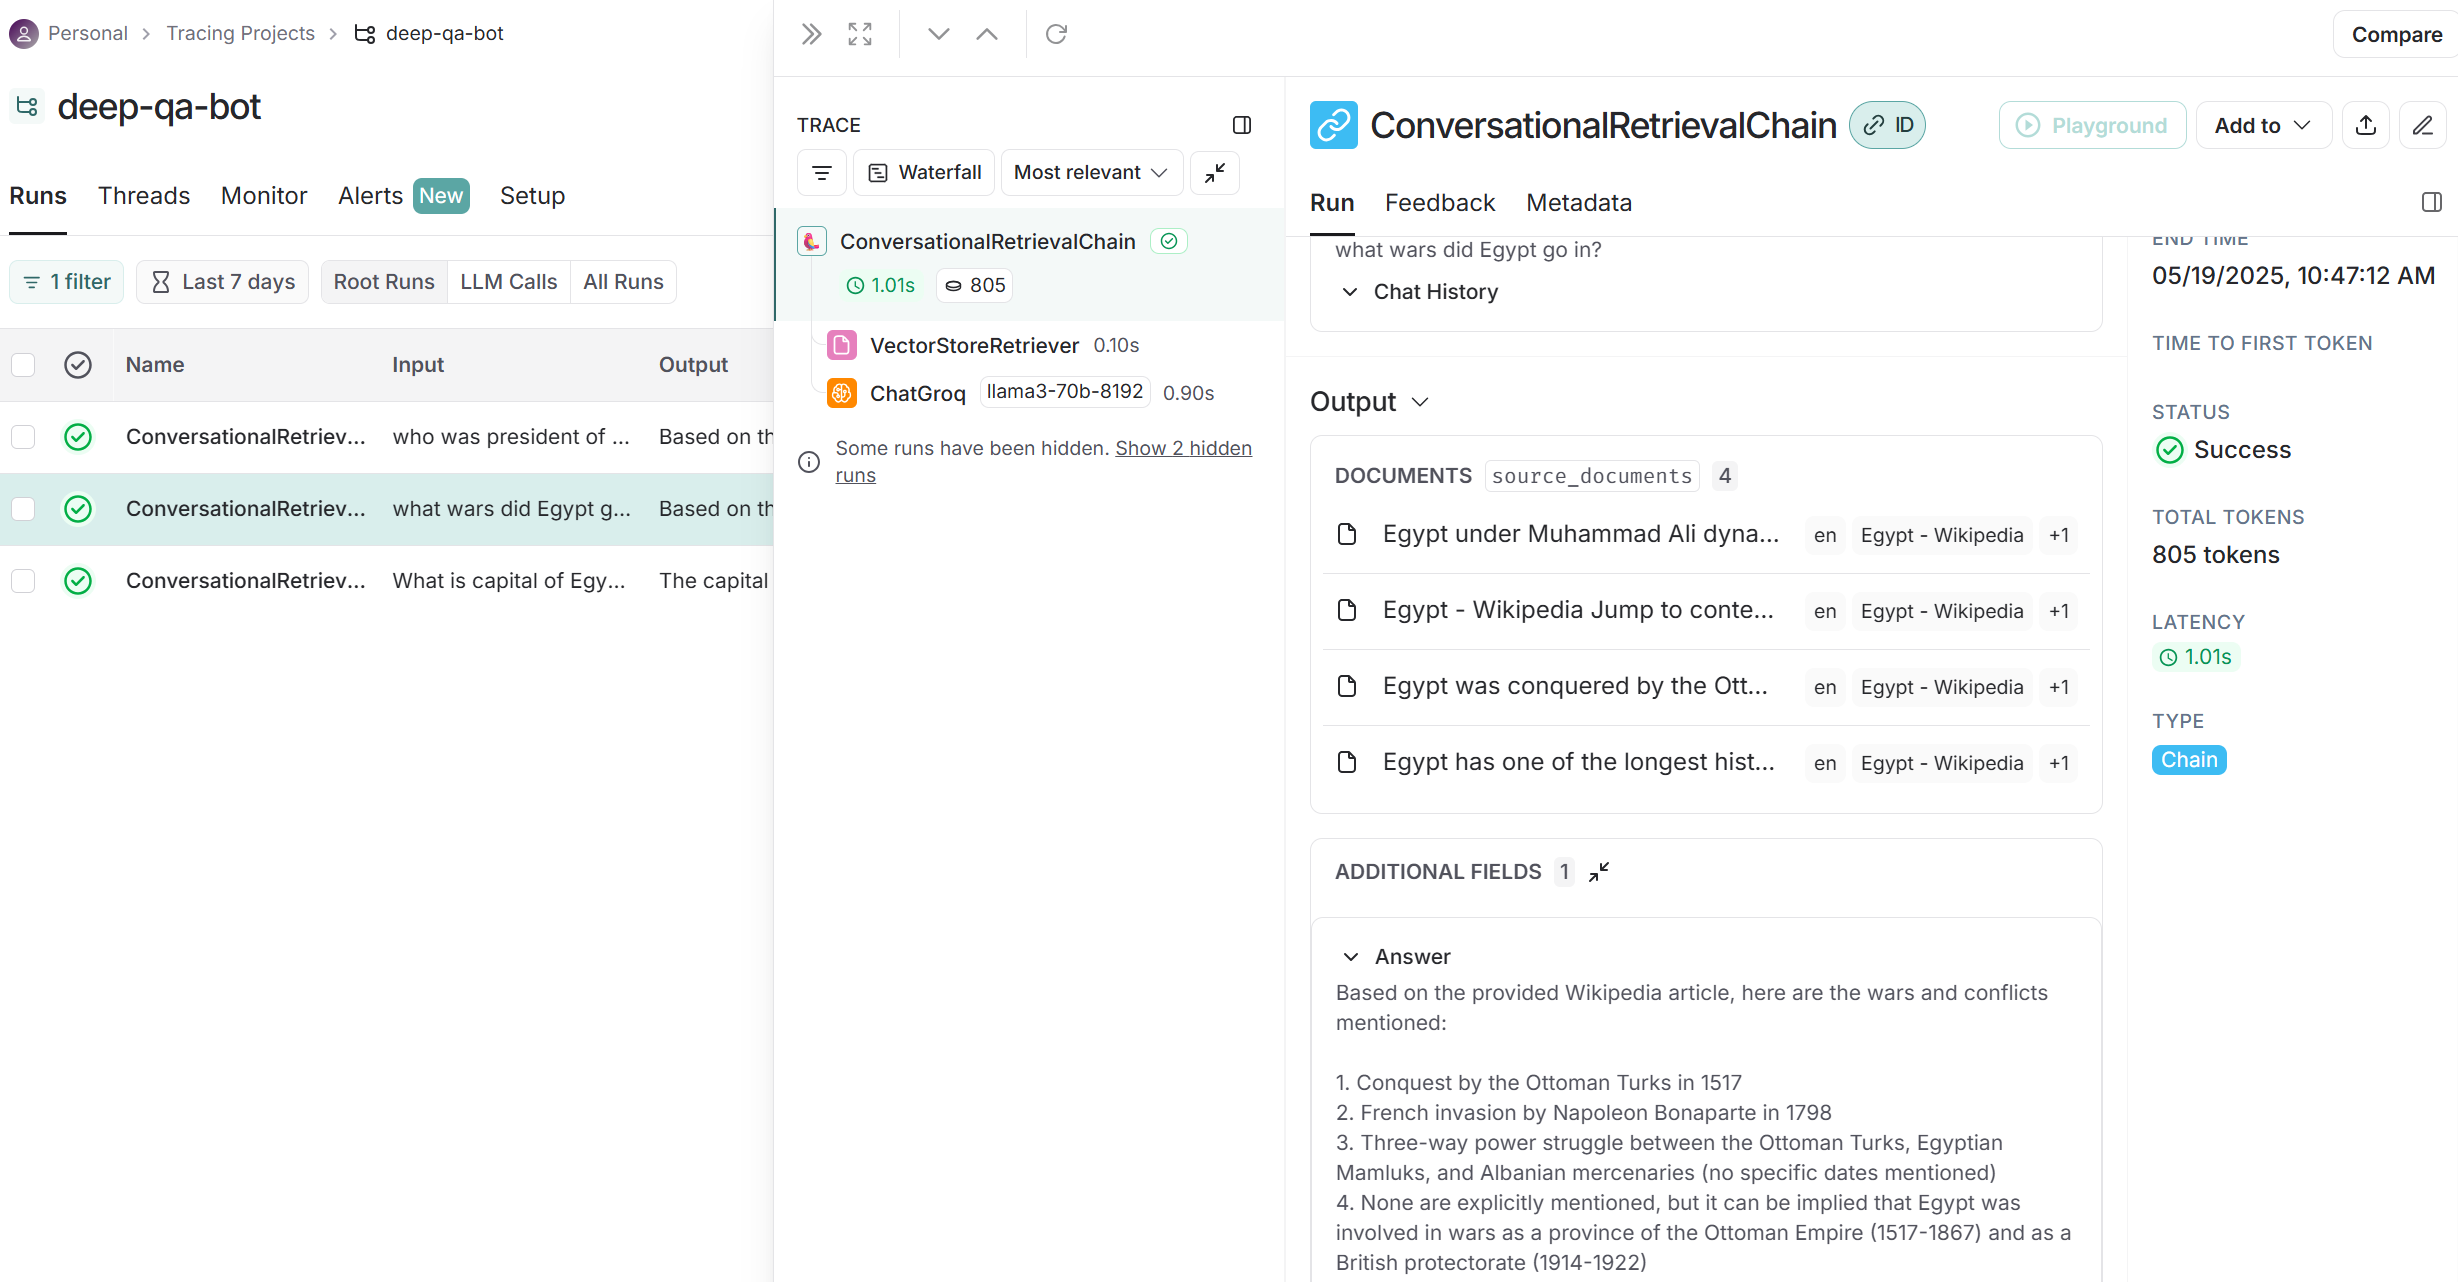

In [11]:
chat_history = [(query, result["answer"])]

query = "who was president of Egypt then?"
result = chain({"question": query, "chat_history": chat_history})

print(result['answer'])

Based on the provided context, here are the presidents of Egypt during the mentioned periods of wars and conflicts:

* 1948 Arab-Israeli War: King Farouk (not a president, but a king)
* Suez Crisis: Gamal Abdel Nasser
* Six-Day War: Gamal Abdel Nasser
* Yom Kippur War: Anwar El-Sadat
* Egyptian-Libyan War: Anwar El-Sadat
* Assassination of Anwar Sadat: Anwar El-Sadat (until his assassination)

Note that the 2011 Egyptian revolution and the 2013 Rabaa massacre occurred during the presidency of Mohamed Morsi and Adly Mansour, respectively.


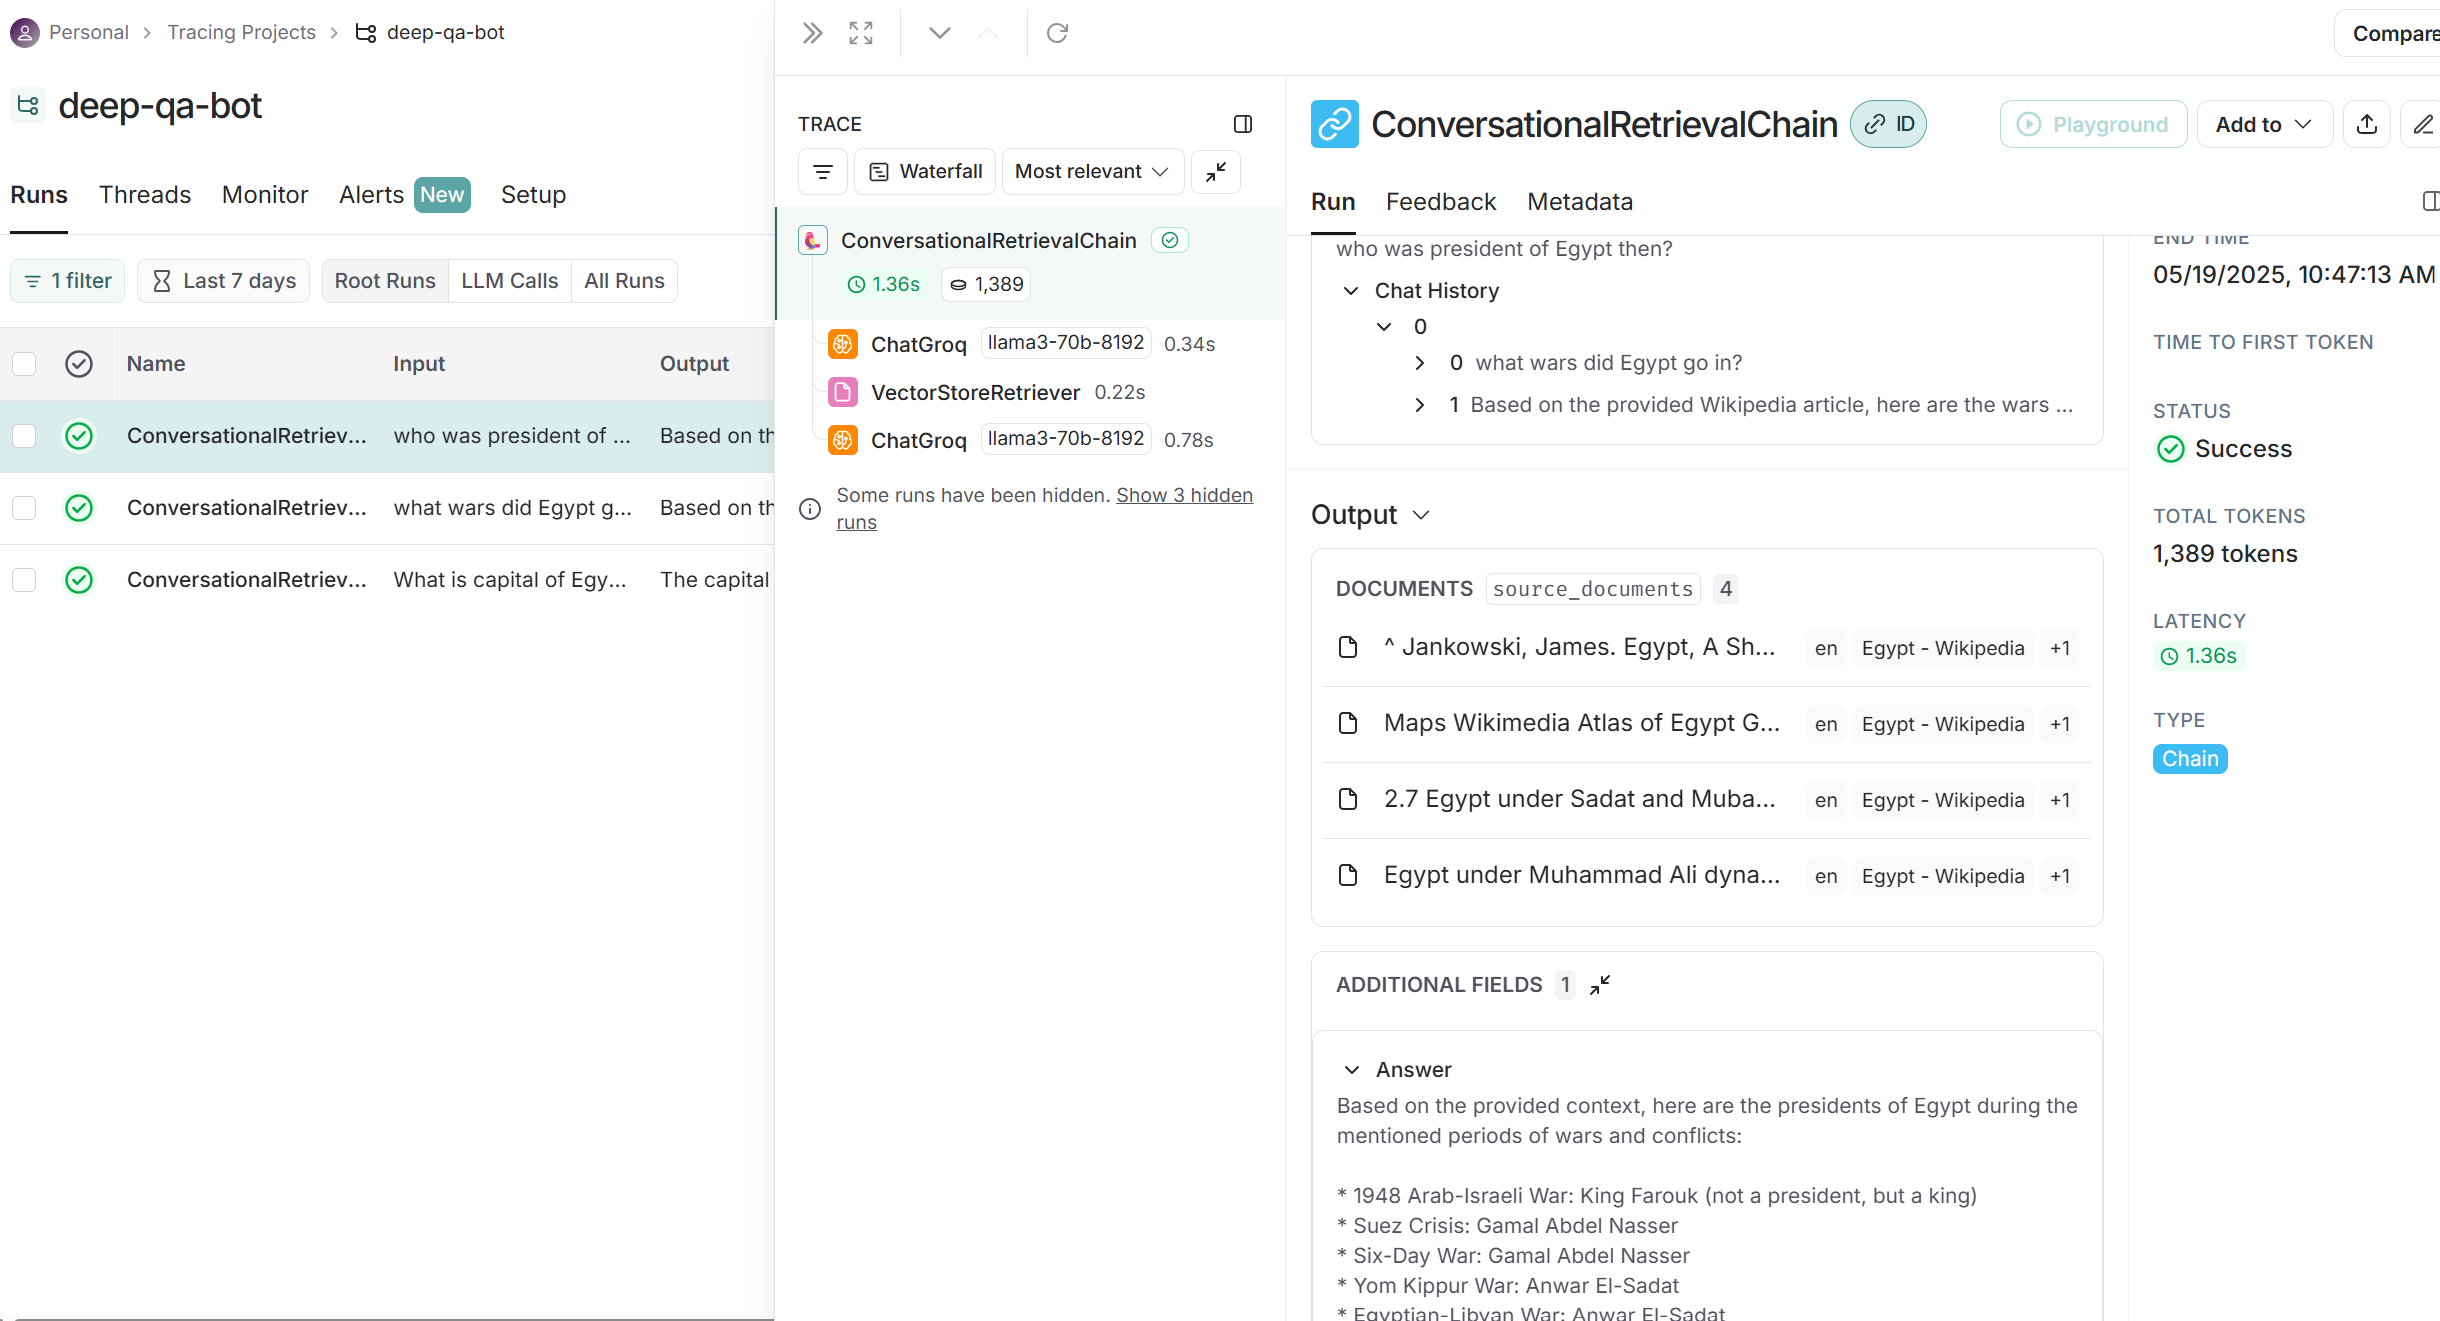

In [13]:
chat_history = [(query, result["answer"])]

query = "what revolutions occured in Egypt ?"
result = chain({"question": query, "chat_history": chat_history})

print(result['answer'])

According to the provided context, there were two revolutions in Egypt:

1. The Egyptian Revolution of 1952, which occurred on 22-23 July 1952, led by Muhammad Naguib and Gamal Abdel Nasser against King Farouk I.
3. The 2011 Egyptian revolution, which began on 25 January 2011, against Hosni Mubarak's government, leading to his resignation on 11 February 2011.


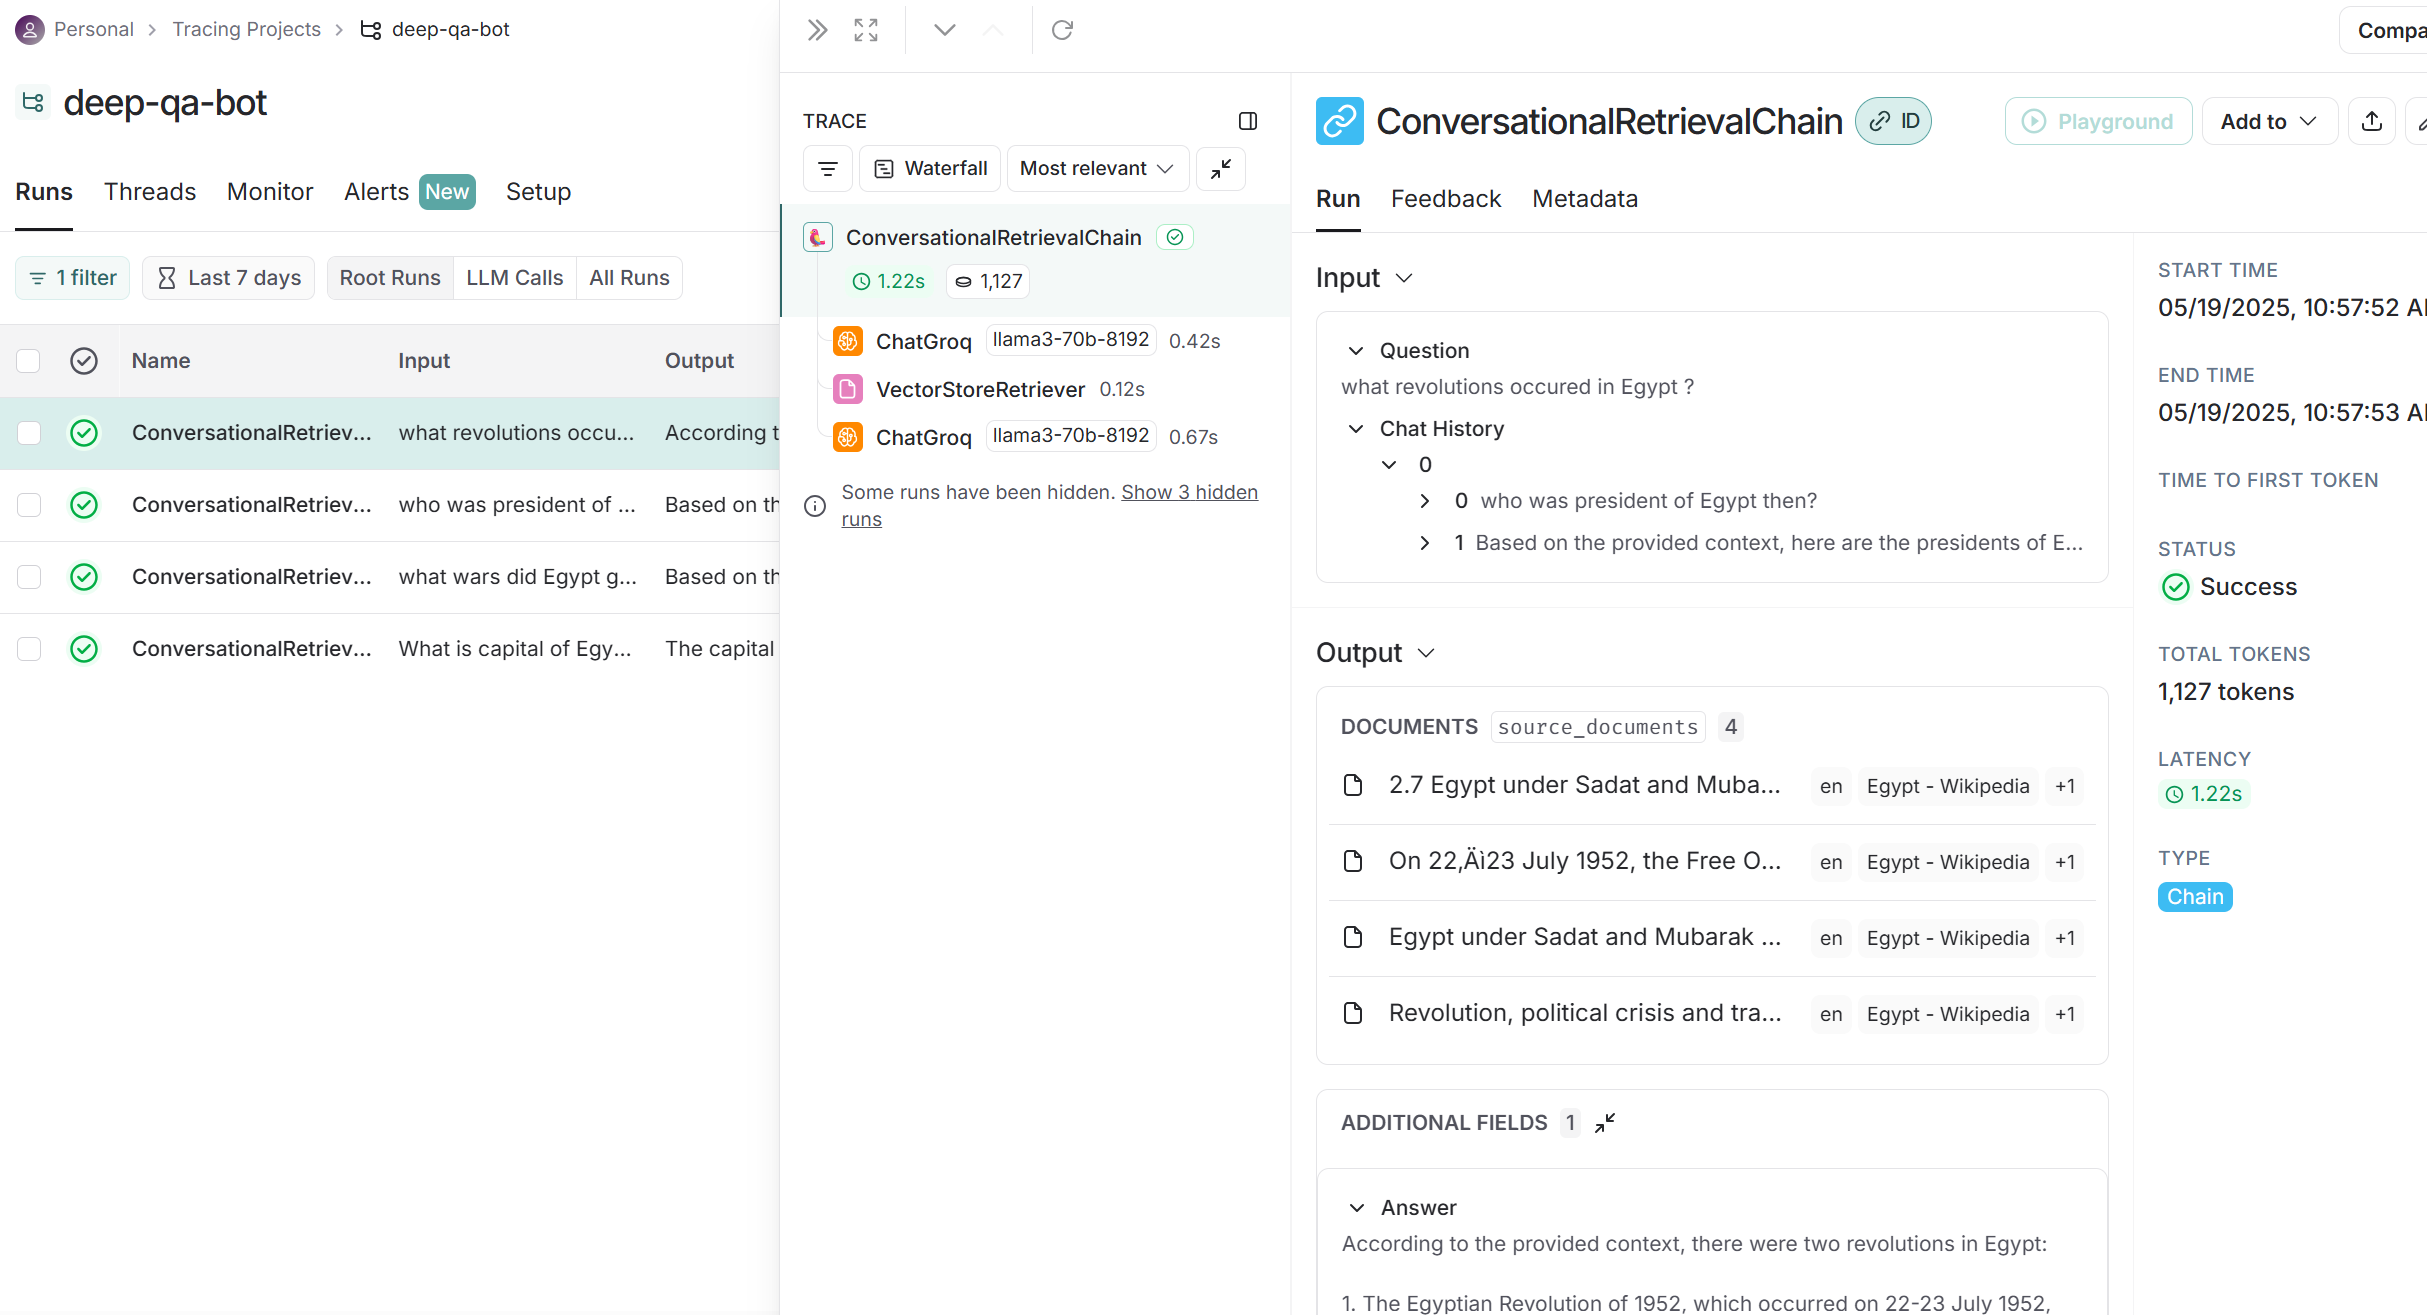